In [1]:
from __future__ import absolute_import,division,print_function

import tensorflow as tf
import numpy as np

# **MNIST dataset Parameters:**


In [13]:
num_classes = 10 # Why? Becasue: Total classes (0-9 digits)
num_features = 784 # data features in our input that is (28X28 = 784)


# Training Parameters:
learning_rate = 0.001
training_steps = 3000
batch_size = 256


display_step = 100



# Neural Network Parameters:
n_hidden_1 = 128 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons

# **Preparing MNIST Data:**

In [27]:
from tensorflow.keras.datasets import mnist
(x_train,y_train),(x_test,y_test) = mnist.load_data()


# Converting to float32:
x_train,x_test = np.array(x_train,np.float32), np.array(x_test,np.float32) # Convert to float32 directly


# Flattening images to 1D vector of 784 features (28X28)
x_train , x_test = x_train.reshape([-1,num_features]), x_test.reshape([-1,num_features])



#Normalizing Image values from [0,255] ---> [0,1]
x_train,x_test = x_train/255. , x_test/255.    # Why '.' ? - I want the output as decimal numbers

In [28]:
# using of tf.data API to shuffle and batch data:

train_data = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

# **Storing layers weights and biases:**

In [29]:
# Initializing weights with random numbers:

random_normal = tf.initializers.RandomNormal()

weights = {
    "h1": tf.Variable(random_normal([num_features,n_hidden_1])),
    "h2": tf.Variable(random_normal([n_hidden_1,n_hidden_2])),
    "output": tf.Variable(random_normal([n_hidden_2,num_classes]))
}


biases = {
    "b1": tf.Variable(random_normal([n_hidden_1])), # By default ',1' added here: (128,1)
    "b2": tf.Variable(random_normal([n_hidden_2])), # By default ',1' added here: (256,1)
    "output": tf.Variable(random_normal([num_classes])) # By default ',1' added here: (10,1)
}

# **Shapes of Weights and Biases:**

In [30]:
print("Shape of W1: ",weights["h1"].shape)
print("Shape of W2: ",weights["h2"].shape)
print("Shape of Wout: ",weights["output"].shape)


print("Shape of b1: ",biases["b1"].shape)
print("Shape of b2: ",biases["b2"].shape)
print("Shape of bout: ",biases["output"].shape)

Shape of W1:  (784, 128)
Shape of W2:  (128, 256)
Shape of Wout:  (256, 10)
Shape of b1:  (128,)
Shape of b2:  (256,)
Shape of bout:  (10,)


# **Creating ModeL:**

In [31]:
def neural_net(x):
  # Hidden fully connected Layer with 128 neuron
  layer_1 = tf.add(tf.matmul(x,weights["h1"]),biases["b1"])


  # Applying sigmoid to layer_1 output for non-linearity
  layer_1 = tf.nn.sigmoid(layer_1) # A1



  # Hidden fully connected Layer with 256 neurons
  layer_2 = tf.add(tf.matmul(layer_1,weights["h2"]),biases["b2"])


  # Applying sigmoid to layer_2 output:
  layer_2 = tf.nn.sigmoid(layer_2) # A2


  # Output fully connected layer with a neuron for each class ----> 10
  out_layer = tf.matmul(layer_2,weights["output"]) + biases["output"]  # 23


  # Applying softmax to normalize the logits
  return tf.nn.softmax(out_layer)

# **Cross-Entropy Loss Function and Accuracy:**


In [32]:
def cross_entropy(y_pred,y_true):
  # Encoding label to one hot vector:
  y_true = tf.one_hot(y_true,depth=num_classes)


  # Clipping prediction values to avoid log(0) error:
  y_pred = tf.clip_by_value(y_pred,1e-9,1.) # Min:1. and Max:1e-9


  # Computing cross-entropy Loss:
  return tf.reduce_mean(-tf.reduce_sum(y_true*tf.math.log(y_pred)))





#Accuracy Metrics:

def accuracy(y_pred,y_true):
  # Predicted class is the index of highest score in prediction vector
  correct_prediction = tf.equal(tf.argmax(y_pred,1),tf.cast(y_true,tf.int64))

  return tf.reduce_mean(tf.cast(correct_prediction,tf.float32),axis=-1)

  # First I calculated the True and False values; and then calculated the Avg of True and Flase values. That is our Accuracy!



# **Stochastic Gradient Descent Optimizer:**

In [33]:
optimizer = tf.optimizers.SGD(learning_rate)

# **Optimizing Process:**

In [34]:
def run_optimization(x,y):
  # Wrapping computation inside a GradientTape for Automatic Difeerentiation

  with tf.GradientTape() as g:
    pred = neural_net(x)
    loss = cross_entropy(pred,y)

  # Variable to Update that is trainable Variables during BackPropagation:
  trainable_variables = list(weights.values()) + list(biases.values())


  # Computing Gradients:
  gradients = g.gradient(loss,trainable_variables)



  # Updating Weights and Biases:
  optimizer.apply_gradients(zip(gradients,trainable_variables)) # If you want to iterate parallely that's why used 'zip'


# **Running training for the given number of steps:**

In [35]:
for step, (batch_x,batch_y) in enumerate(train_data.take(training_steps),1):

  # Running the optimization to update W and b values after each batch:
  run_optimization(batch_x,batch_y) # Training our Model batch by batch



  if step % display_step == 0: # Display step: After certain number of iterations Display the accuracy, Details
    pred = neural_net(batch_x) # In that case we'll get the predictions
    loss = cross_entropy(pred,batch_y) # In that case we'll get the loss
    acc = accuracy(pred,batch_y) # In that case we'll get the accuracy


    print(f"Step: {step}, Loss: {loss}, Accuracy: {acc}")


  # What's happening? - After the optimization is run for 200/100/300 steps we'll keep calculating the predcitions of our current model predicting


Step: 100, Loss: 561.2982788085938, Accuracy: 0.25
Step: 200, Loss: 399.4688720703125, Accuracy: 0.44921875
Step: 300, Loss: 239.897216796875, Accuracy: 0.70703125
Step: 400, Loss: 172.02215576171875, Accuracy: 0.79296875
Step: 500, Loss: 121.23758697509766, Accuracy: 0.87109375
Step: 600, Loss: 124.77638244628906, Accuracy: 0.875
Step: 700, Loss: 115.24104309082031, Accuracy: 0.88671875
Step: 800, Loss: 107.7684326171875, Accuracy: 0.8828125
Step: 900, Loss: 91.533935546875, Accuracy: 0.89453125
Step: 1000, Loss: 83.97689819335938, Accuracy: 0.921875
Step: 1100, Loss: 90.8178482055664, Accuracy: 0.90234375
Step: 1200, Loss: 73.23727416992188, Accuracy: 0.92578125
Step: 1300, Loss: 72.18690490722656, Accuracy: 0.90234375
Step: 1400, Loss: 69.82976531982422, Accuracy: 0.92578125
Step: 1500, Loss: 86.97704315185547, Accuracy: 0.90234375
Step: 1600, Loss: 71.19776153564453, Accuracy: 0.91796875
Step: 1700, Loss: 74.53482818603516, Accuracy: 0.91796875
Step: 1800, Loss: 88.88006591796875, 

# **Testing Model on Validation Sets:**

In [36]:
pred = neural_net(x_test)

print(f"Test Accuracy: {accuracy(pred,y_test)}")

Test Accuracy: 0.9375


# **Visual Prediction Comparisons:**

In [37]:
import matplotlib.pyplot as plt

#**Predicting Images from the Validation set:**

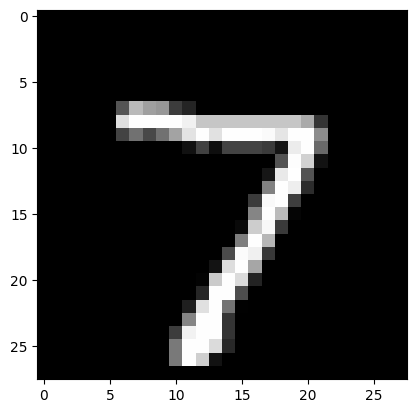

Model Prediction 7


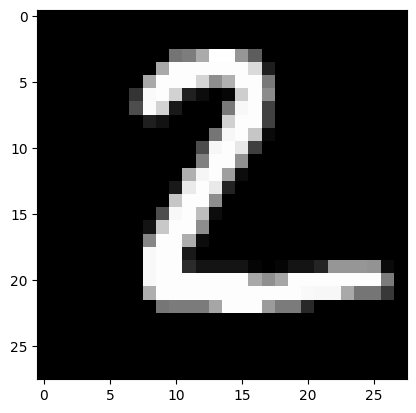

Model Prediction 2


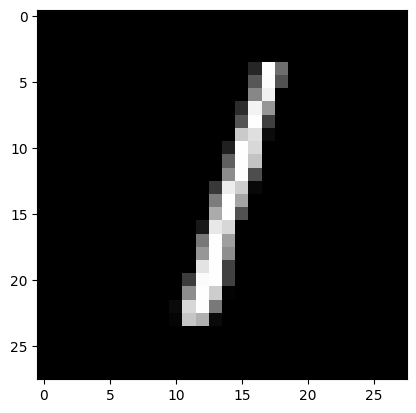

Model Prediction 1


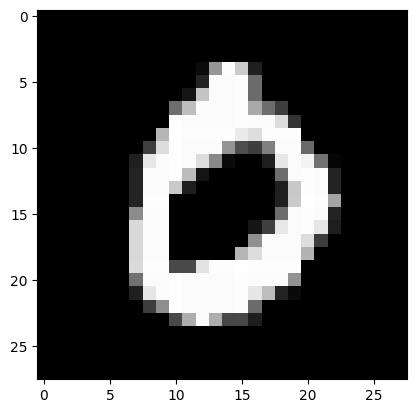

Model Prediction 0


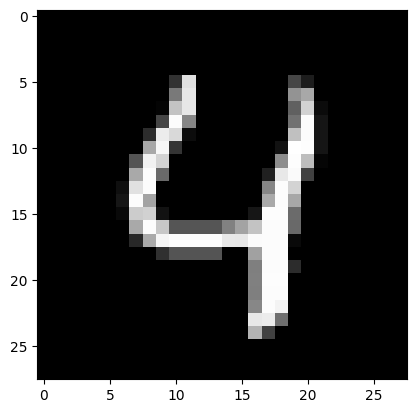

Model Prediction 4


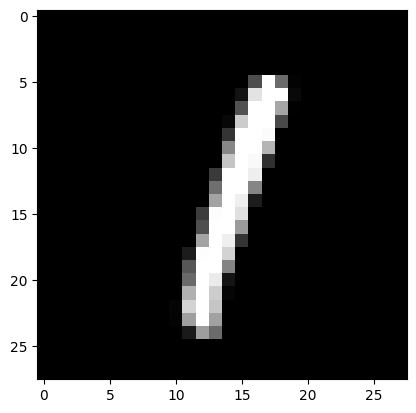

Model Prediction 1


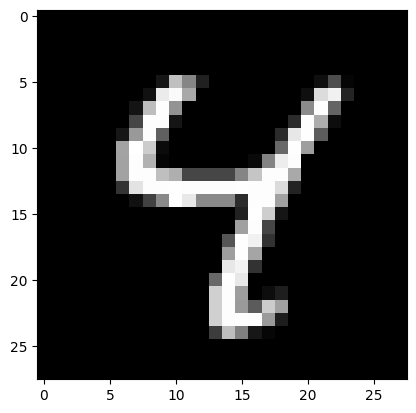

Model Prediction 4


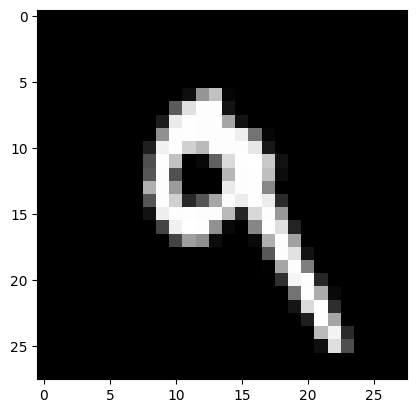

Model Prediction 9


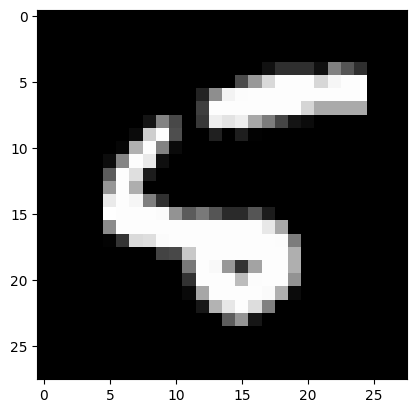

Model Prediction 6


In [39]:
n_images = 9


test_images = x_test[:n_images] # Shape = [5,784]  - 5 images each of 784 / flattened
# we can't use flattened images (distorted) we need to reshape it as it was 2D


predictions = neural_net(test_images) # Prediction dimension: [5,10]



# Displaying image and Model Prediction:
for i in range(n_images):
  plt.imshow(np.reshape(test_images[i],(28,28)),cmap="gray") # Taking the 784 length array and converting it back to 2D array that is the image array that we can print
  plt.show()
  print(f"Model Prediction {np.argmax(predictions.numpy()[i])}") # Printing the Predictions if the Predictions were cocrrect and then printing the Index (Number)
